<h1>FMCG(Fast-Moving Consumer Goods)</h1>
<h3>Recognition of Product Positions on Shelf Images using Deep Learning</h3>

<h3>Dependencies</h3>

Solution depends on the following main libraries:
*   Tensorlfow
*   Keras
*   Tensorflow Object Detection API
*   OpenCV

## Steps

All steps are implemented as jupyter notebooks and could be read without execution:
*   Step 1 - Initial Data Preparation
*   Step 2 - Brands Recognition with ResNet CNN
*   Step 3 - Training SSD for Products Detection
*   Step 4 - Implementing Products Detection



<h1>Step 1 - Initial Data Preparation</h1>


<br/>
Unfortunately, some of images are rotated. It can be fixed using following commands:
<ul style="list-style-type:none">
<li>convert C1_P03_N1_S2_1.JPG -rotate 180 C1_P03_N1_S2_1.JPG</li>
<li>convert C1_P03_N1_S2_2.JPG -rotate 180 C1_P03_N1_S2_2.JPG</li>
<li>convert C1_P03_N1_S3_1.JPG -rotate 180 C1_P03_N1_S3_1.JPG</li>
<li>convert C1_P03_N1_S3_2.JPG -rotate 180 C1_P03_N1_S3_2.JPG</li>
<li>convert C1_P03_N1_S4_1.JPG -rotate 180 C1_P03_N1_S4_1.JPG</li>
<li>convert C1_P03_N1_S4_2.JPG -rotate 180 C1_P03_N1_S4_2.JPG</li>
<li>convert C1_P03_N2_S3_1.JPG -rotate 180 C1_P03_N2_S3_1.JPG</li>
<li>convert C1_P03_N2_S3_2.JPG -rotate 180 C1_P03_N2_S3_2.JPG</li>
<li>convert C1_P03_N3_S2_1.JPG -rotate 180 C1_P03_N3_S2_1.JPG</li>
<li>convert C1_P12_N1_S2_1.JPG -rotate 180 C1_P12_N1_S2_1.JPG</li>
<li>convert C1_P12_N1_S3_1.JPG -rotate 180 C1_P12_N1_S3_1.JPG</li>
<li>convert C1_P12_N1_S4_1.JPG -rotate 180 C1_P12_N1_S4_1.JPG</li>
<li>convert C1_P12_N1_S5_1.JPG -rotate 180 C1_P12_N1_S5_1.JPG</li>
<li>convert C1_P12_N2_S2_1.JPG -rotate 180 C1_P12_N2_S2_1.JPG</li>
<li>convert C1_P12_N2_S3_1.JPG -rotate 180 C1_P12_N2_S3_1.JPG</li>
<li>convert C1_P12_N2_S4_1.JPG -rotate 180 C1_P12_N2_S4_1.JPG</li>
<li>convert C1_P12_N2_S5_1.JPG -rotate 180 C1_P12_N2_S5_1.JPG</li>
<li>convert C1_P12_N3_S2_1.JPG -rotate 180 C1_P12_N3_S2_1.JPG</li>
<li>convert C1_P12_N3_S3_1.JPG -rotate 180 C1_P12_N3_S3_1.JPG</li>
<li>convert C1_P12_N3_S4_1.JPG -rotate 180 C1_P12_N3_S4_1.JPG</li>
<li>convert C1_P12_N4_S2_1.JPG -rotate 180 C1_P12_N4_S2_1.JPG</li>
<li>convert C1_P12_N4_S3_1.JPG -rotate 180 C1_P12_N4_S3_1.JPG</li>
<li>convert C3_P07_N1_S6_1.JPG -rotate -90 C3_P07_N1_S6_1.JPG</li></ul>

I'll use data from two folders:
<h3>ShelfImages</h3>
Directory contains JPG files named the same way as C3_P06_N3_S3_1.JPG file:
<ul>
    <li>C3_P06 - shelf id</li>
    <li>N3_S3_1 - planogram id</li>
</ul>
<h3>ProductImagesFromShelves</h3>
Directory contains png files grouped by category named the same way as C1_P01_N1_S2_1.JPG_1008_1552_252_376.png file:
<ul>
    <li>C1_P01_N1_S2_1.JPG - shelf photo file</li>
    <li>1008 - x</li>
    <li>1552 - y</li>
    <li>252 - w</li>
    <li>376 - h</li>
</ul>

In [ ]:
#importing libraries 
import cv2
import pandas as pd
from matplotlib import pyplot as plt
import os
import numpy as np
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
data_path = 'data/'
# we'll use data from two folders
shelf_images = 'data/images/ShelfImages/'
product_images = 'data/images/ProductImagesFromShelves/'

In [3]:
# All shelves photo data from ShelfImages
jpg_files = [f for f in os.listdir(f'{shelf_images}') if f.endswith('JPG')]
photos_df = pd.DataFrame([[f, f[:6], f[7:14]] for f in jpg_files], 
                         columns=['file', 'shelf_id', 'planogram_id'])
photos_df.head()

file shelf_id planogram_id
0  C3_P06_N3_S3_1.JPG   C3_P06      N3_S3_1
1  C1_P06_N3_S3_1.JPG   C1_P06      N3_S3_1
2  C2_P08_N3_S3_1.JPG   C2_P08      N3_S3_1
3  C2_P08_N1_S3_2.JPG   C2_P08      N1_S3_2
4  C1_P10_N1_S4_1.JPG   C1_P10      N1_S4_1

In [5]:
# Products on shelves photo from ProductImagesFromShelves
products_df = pd.DataFrame(
    [[f[:18], f[:6], f[7:14], i, *map(int, f[19:-4].split('_'))] 
     for i in range(11) 
     for f in os.listdir(f'{product_images}{i}') if f.endswith('png')],
    columns=['file', 'shelf_id', 'planogram_id', 
             'category', 'xmin', 'ymin', 'w', 'h'])
# convert from width height to xmax, ymax
products_df['xmax'] = products_df['xmin'] + products_df['w']
products_df['ymax'] = products_df['ymin'] + products_df['h']
products_df.head()

file shelf_id planogram_id  category  xmin  ymin    w    h  \
0  C1_P08_N2_S3_1.JPG   C1_P08      N2_S3_1         0  1812   300  212  396   
1  C4_P07_N2_S4_1.JPG   C4_P07      N2_S4_1         0   312  1716  160  284   
2  C2_P01_N2_S3_2.JPG   C2_P01      N2_S3_2         0  1468  1244  140  204   
3  C1_P12_N2_S5_1.JPG   C1_P12      N2_S5_1         0   236  2092  164  260   
4  C1_P08_N3_S4_2.JPG   C1_P08      N3_S4_2         0   740  1488  208  328   

   xmax  ymax  
0  2024   696  
1   472  2000  
2  1608  1448  
3   400  2352  
4   948  1816

<h1>Train/Validation/Test Split</h1>
It's a good practice to split the data into three categories: train (neural network training), validation (monitor training process in order not to over fit our nn) and test (apply final performance checks).<br>
For our purposes we will split the data into train/validation in 70/30 ratio.<br>


In [8]:
# get distinct shelves
shelves = list(set(photos_df['shelf_id'].values))
# use train_test_split from sklearn
shelves_train, shelves_validation, _, _ = train_test_split(
    shelves, shelves, test_size=0.3, random_state=6)
# mark all records in data frames with is_train flag
def is_train(shelf_id): return shelf_id in shelves_train
photos_df['is_train'] = photos_df.shelf_id.apply(is_train)
products_df['is_train'] = products_df.shelf_id.apply(is_train)

The dataset contains 11 classes. Class 0 is "garbage" (unclassified data). Class 1 is Marlboro, 2 - Kent, 3 - Camel etc. It's very important that split contains enough data for training for each class and also enugh data for validation. So, let's visualize our split. Yellow is for training, blue is for testing.

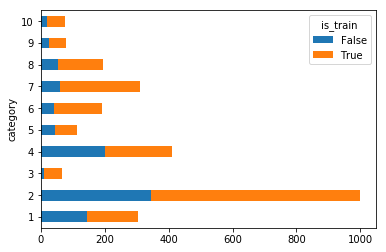

In [9]:
df = products_df[products_df.category != 0].\
         groupby(['category', 'is_train'])['category'].\
         count().unstack('is_train').fillna(0)
df.plot(kind='barh', stacked=True)

In [21]:
# save to pkl
photos_df.to_pickle(f'{data_path}photos.pkl')
products_df.to_pickle(f'{data_path}products.pkl')

In [12]:
# function to display shelf photo with rectangled products
def draw_shelf_photo(file):
    file_products_df = products_df[products_df.file == file]
    coordinates = file_products_df[['xmin', 'ymin', 'xmax', 'ymax']].values
    im = cv2.imread(f'{shelf_images}{file}')
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)    
    for xmin, ymin, xmax, ymax in coordinates:
        cv2.rectangle(im, (xmin, ymin), (xmax, ymax), (0, 255, 0), 5)
    plt.imshow(im)

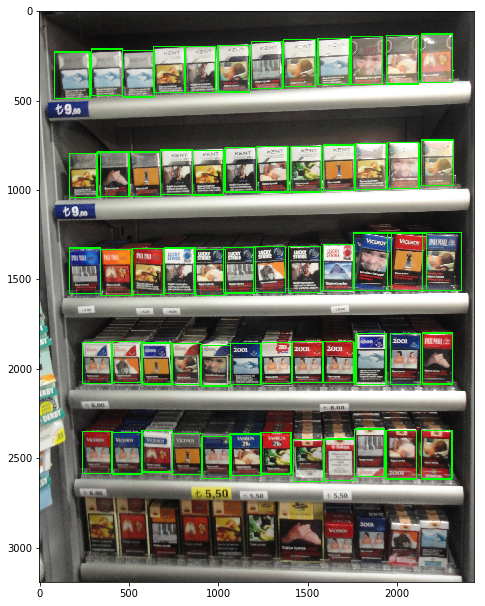

In [13]:
# draw one photo to check our data
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
draw_shelf_photo('C3_P07_N1_S6_1.JPG')